In [1]:
!pip install face_recognition

In [2]:
from google.colab.patches import cv2_imshow

In [3]:
import cv2
import face_recognition
import numpy as np

def locate_faces(frame):
    """Detects faces in a frame using OpenCV and face_recognition. we can use other deep NN AlgorithM (SSD,YOLO etc)

    Args:
        frame: A NumPy array representing the video frame.

    Returns:
        A list of (top, right, bottom, left) tuples for each detected face.
    """
    rgb_frame = frame[:, :, ::-1]  # Convert BGR to RGB for face_recognition
    face_locations = face_recognition.face_locations(rgb_frame)
    return face_locations

In [4]:
   def determine_usable_region(frame, aspect_ratio="9:16", face_locations=None):
    """Finds the maximum usable space within the safezone without intersecting faces.

    Args:
        frame: A NumPy array representing the video frame.
        aspect_ratio: The aspect ratio of the video (e.g., "9:16" or "16:9").
        face_locations: A list of (top, right, bottom, left) tuples for each detected face.

    Returns:
        A tuple (x1, y1, x2, y2) representing the maximum usable space coordinates.
    """
    frame_height, frame_width, _ = frame.shape
    safezone_x1, safezone_y1, safezone_x2, safezone_y2 = get_safezone_coordinates(frame, aspect_ratio)

    usable_x1, usable_y1, usable_x2, usable_y2 = safezone_x1, safezone_y1, safezone_x2, safezone_y2

    if face_locations:
        face_margin = 0.05  # Adjust margin as needed
        for top, right, bottom, left in face_locations:
            # Update usable space based on each face location, considering margins
            usable_x1 = max(usable_x1, left + face_margin * frame_width)
            usable_y1 = max(usable_y1, top + face_margin * frame_height)
            usable_x2 = min(usable_x2, right - face_margin * frame_width)
            usable_y2 = min(usable_y2, bottom - face_margin * frame_height)

    return usable_x1, usable_y1, usable_x2, usable_y2

In [5]:
def get_safezone_coordinates(frame, aspect_ratio="9:16"):
    """Retrieves the safezone coordinates for the given aspect ratio.

    Args:
        frame: A NumPy array representing the video frame.
        aspect_ratio: The aspect ratio of the video (e.g., "9:16" or "16:9").

    Returns:
        A tuple (x1, y1, x2, y2) representing the safezone coordinates.
    """
    frame_height, frame_width, _ = frame.shape

    if aspect_ratio == "9:16":
        # placeholder values with safezone coordinates from the image for 9:16 aspect ratio
       safezone_x1, safezone_y1, safezone_x2, safezone_y2 = 0.05, 0.15 , 0.80 , 0.80 # as mentioned in Image
    else:
        raise ValueError("Unsupported aspect ratio:", aspect_ratio)

    return int(safezone_x1 * frame_width), int(safezone_y1 * frame_height), \
           int(safezone_x2 * frame_width), int(safezone_y2 * frame_height)

In [20]:
def partition_video_content(video_path, similarity_threshold=0.2, min_shot_length=0.5):

    cap = cv2.VideoCapture(video_path)

    # Get video fps and aspect ratio
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    aspect_ratio = f"{frame_width}:{frame_height}"

    # Initialize variables
    current_frame = None
    previous_frame = None
    current_scene = []
    scenes = []
    frame_count = 0
    scene_start_time = None
    scene_start_frame = 0  # Initialize scene_start_frame here
    safezone_text_area =[]

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Convert to grayscale for faster comparison
        grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Display the frame with optional user interaction

        # Detect faces in the frame
        face_locations = locate_faces(frame)

        # find area where text can be placed
        safezone_x1, safezone_y1, safezone_x2, safezone_y2 = determine_usable_region(frame,"9:16",face_locations)
        safezone_text_area.append((safezone_x1, safezone_y1, safezone_x2, safezone_y2))

        # This is to test where we are detecting the face or not
        # if (len(face_locations)) != 0:
        #   print(frame_count,face_locations)

        if frame_count >= 1200 and frame_count < 1510 :
          # print boundary box around face
          for top,right,bottom,left in face_locations:
            img = cv2.rectangle(frame,(left, top), (right, bottom),(0,255,0),3)
            cv2_imshow(img)

        # print(face_locations)
        # Fast-cut detection based on frame similarity
        if current_frame is not None:
            diff = np.abs(previous_frame - grayscale_frame).mean()
            if diff > similarity_threshold:
                # Scene change detected
                if scene_start_time is not None and frame_count - scene_start_frame >= fps * min_shot_length:
                    scenes.append(current_scene)
                current_scene = []
                scene_start_time = frame_count / fps
                scene_start_frame = frame_count

        current_scene.append((frame, face_locations))
        current_frame = grayscale_frame
        previous_frame = current_frame
        frame_count += 1
        # print(frame_count)
    # Add the last scene if it meets the minimum length requirement
    if scene_start_time is not None and frame_count - scene_start_frame >= fps * min_shot_length:
        scenes.append(current_scene)

    cap.release()

    return scenes

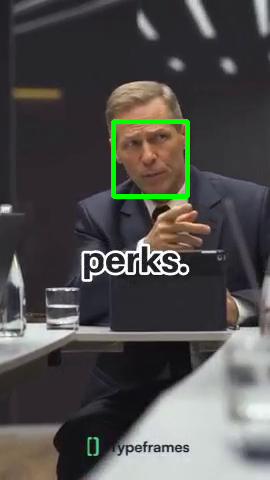

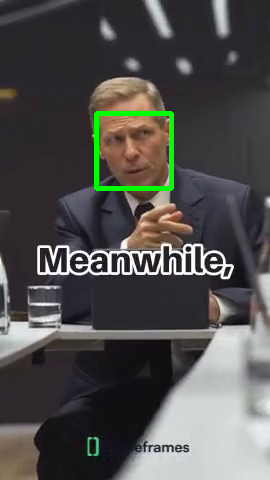

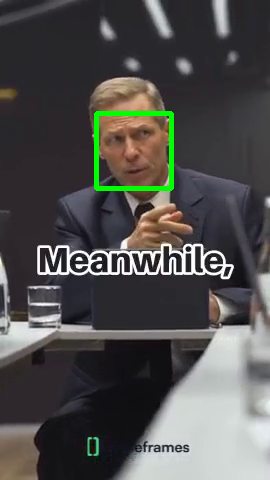

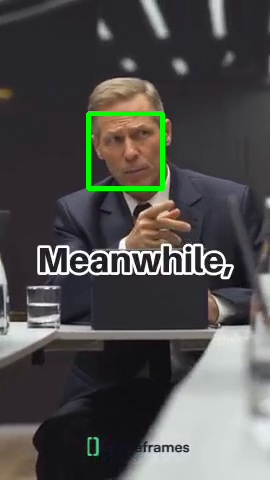

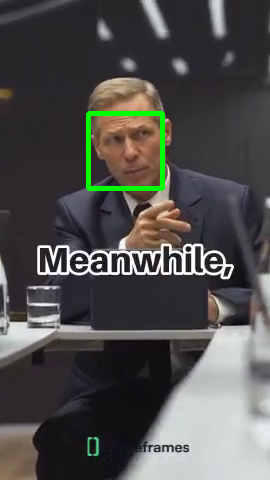

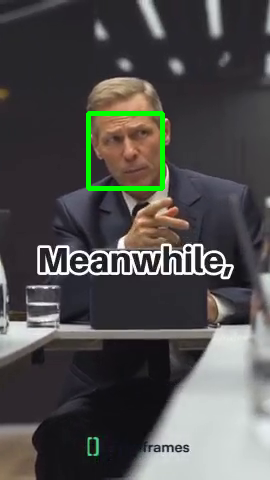

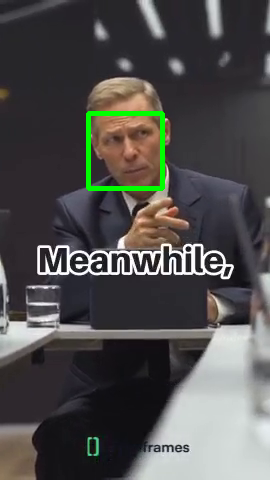

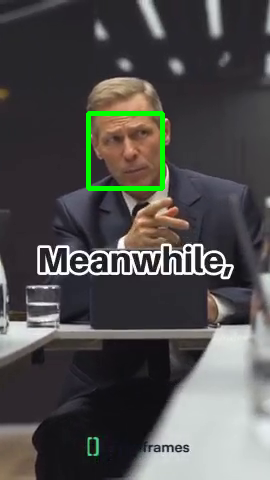

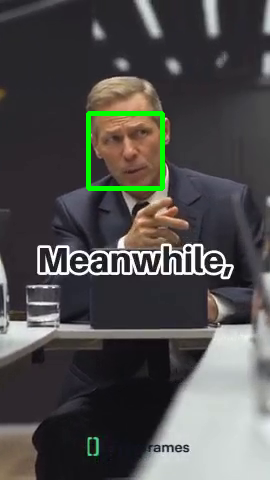

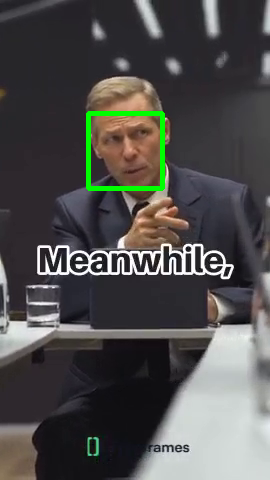

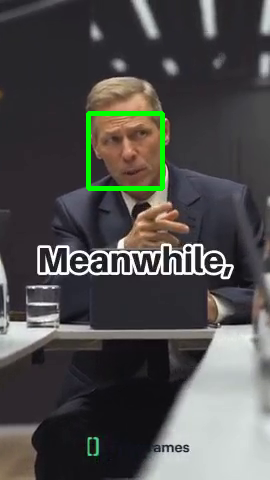

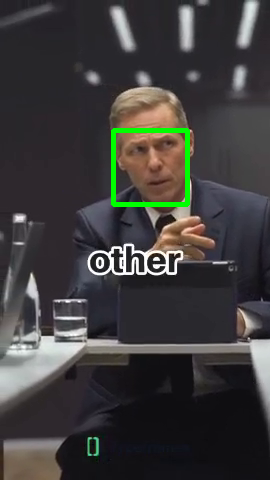

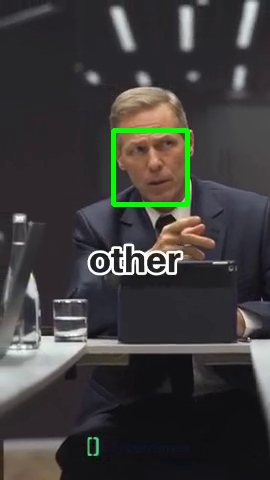

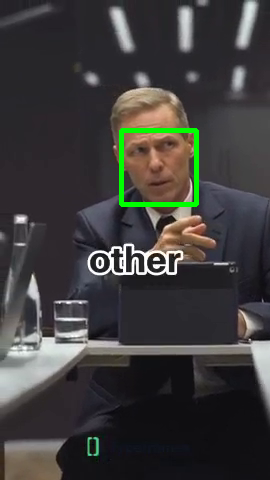

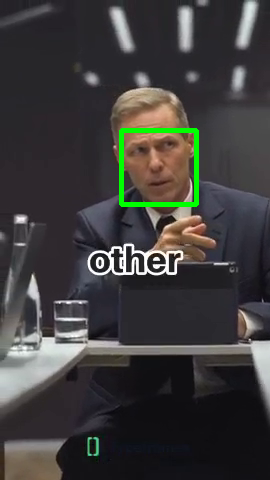

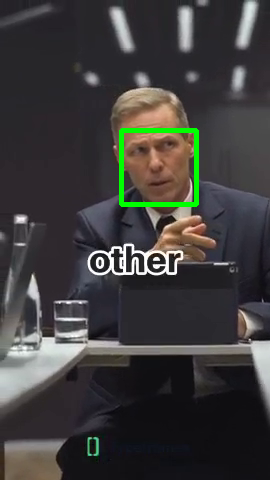

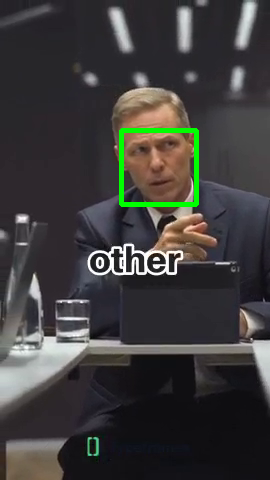

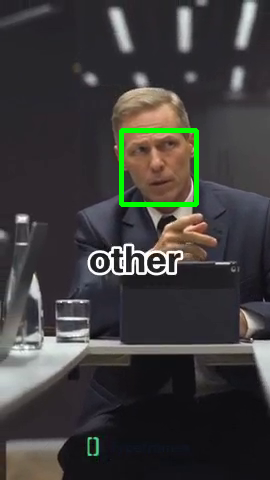

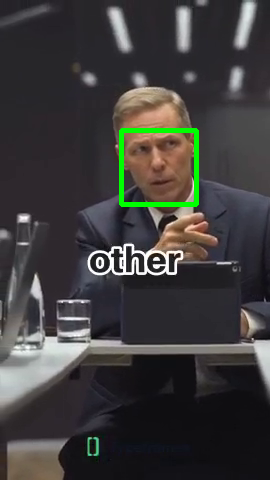

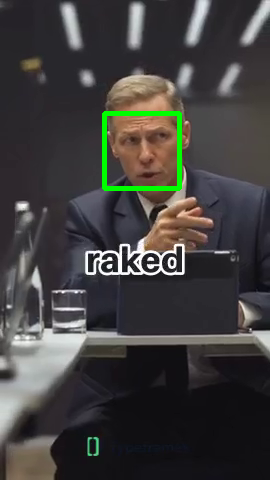

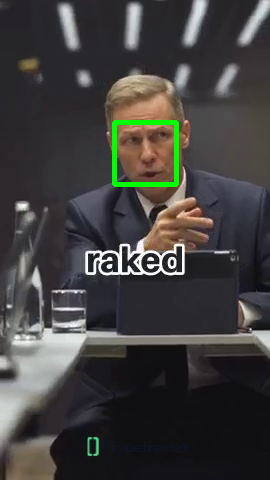

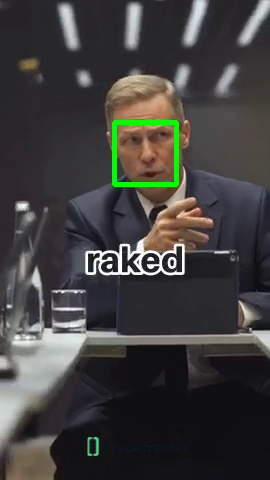

KeyboardInterrupt: 

In [21]:
video_path = "/content/Single Narration Video.mp4"
partition_video_content(video_path)